## 🎯 Objective

This app predicts how much of a loan will be granted to an applicant. For this task, I use a dataset from kaggle, which contains historical information about applicants which can be used to predict loan amount. Below are all the columns from the dataset I’m using here:

- Customer ID,
- Name
- Gender
- Age
- Income (USD)
- Income Stability
- Profession
- Type of Employment
- Location 
- Loan Amount Request (USD)
- Current Loan Expenses (USD)
- Expense Type 1 
- Expense Type 2
- Dependents
- Credit Score
- No. of Defaults
- Has Active Credit Card
- Property ID
- Property Age
- Property Type
- Property Location
- Co-Applicant
- Property Price 
- Loan Sanction Amount (USD)

## 📌 0. Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from pathlib import Path
from sklearn.metrics import mean_squared_error
from scipy import stats
from yellowbrick.model_selection import FeatureImportances
import joblib
%matplotlib inline

/Users/atefeh/miniconda3/envs/tf2/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 📥 1. Data Preparation


### 1.1 Import csv file

In [3]:
# Load data
train_df = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)
train_df.head(2)

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98


In [4]:
validation_df= pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
validation_df.head(2)

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.5
1,C-35067,Jeannette Cha,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.3


📍 The test dataset does not have the target variable (Loan Amount), we will split the train dataset into a new train and test dataset.

###  1.2 Split the data

In [5]:
# split the data into train and test

def data_split(data):
    new_train , new_test = train_test_split(data, test_size=0.2,random_state=42)
    return  new_train.reset_index(drop=True),new_test.reset_index(drop=True)

In [6]:
loan_amt_train, loan_amt_test = data_split(train_df)

In [7]:
# create a copy from test and train dataset
loan_amt_test_copy = loan_amt_test.copy()
loan_amt_train_copy = loan_amt_train.copy()

## 🔍 2. Data Exploration

### 2.1 Glance at the data

In [8]:
pd.set_option('display.max_columns', None)
pd.DataFrame(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  object 
 13  Dependents      

""


### 2.2 Univariate analysis

In [9]:
# Create a function to print description of each feature
def freq_table(data,feature):
    
    # Calculate the count of each unique value
    count_feature = data[feature].value_counts()

    # Calculate the percentage of each unique value
    percent_count = round(data[feature].value_counts(normalize =True)*100,2)

    # Combine the counts and percentages into a single DataFrame
    table = pd.concat([count_feature,percent_count],axis=1)
    table.columns = ['Count' , 'Percentage %']
    return table


In [10]:
# Select Object features
objetc_feature_1 = train_df.select_dtypes(include=['object']).columns.tolist()
objetc_feature_2 = ['Dependents','No. of Defaults','Property Type','Co-Applicant']
objetc_feature = objetc_feature_1 + objetc_feature_2

In [11]:
# Create a function to give us description and frequency table of each variable
def get_info(data,feature):
   match feature :
      case 'Property Age':
         print(f'Description:\n{(data[feature]/365.25).describe()}' )
         print('*'*50)

# Add frequency table only for object variables
      case _ if  feature in objetc_feature:
         print(f'Description:\n{(data[feature]).describe()}' )
         print('*'*50)
         print(f'Frequency Table\n{freq_table(data,feature)} ')

      case _:  
         print(f'Description:\n{(data[feature]).describe()}' )



In [12]:
# Create a bar plot for each feature

def create_bar_plot(data, feature):
    plt.figure(figsize=(8,6))
    sns.countplot(data=data, x=feature, palette="Set2",hue=feature,dodge=False)    
    plt.legend([],[], frameon=False)  # Remove the legend
    plt.title(f'Distribution of {feature}')           
    plt.xticks(rotation=45,ha='right')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()



In [13]:
# Create box plot

def create_box_plot(data,feature):

    match feature :
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(2, 8))
            sns.boxplot(y=data[feature]/365.25)
            plt.title(f'Distribution of {feature}')
            return plt.show()
        
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=data[feature])
            plt.title(f'Distribution of {feature}')
            return plt.show()
        




In [14]:
# Create histogram for countinous variable.

def create_hist_plot (data, feature):
    match feature:
        case 'Property Age':
            plt.figure(figsize=(15, 10))
            sns.histplot(data[feature]/365.25 , bins= 50 , kde =True)
            plt.title(f'Distribution of {feature}')
            return plt.show()
        
        case _:
            plt.figure(figsize=(15, 10))
            sns.histplot(data[feature] , bins= 50 , kde =True)
            plt.title(f'Distribution of {feature}')
            return plt.show()


#### Gender :

We have almost the same number of Male and Female.


In [15]:
get_info(loan_amt_train_copy,'Gender')

Description:
count     23954
unique        2
top           M
freq      12087
Name: Gender, dtype: object
**************************************************
Frequency Table
        Count  Percentage %
Gender                     
M       12087         50.46
F       11867         49.54 


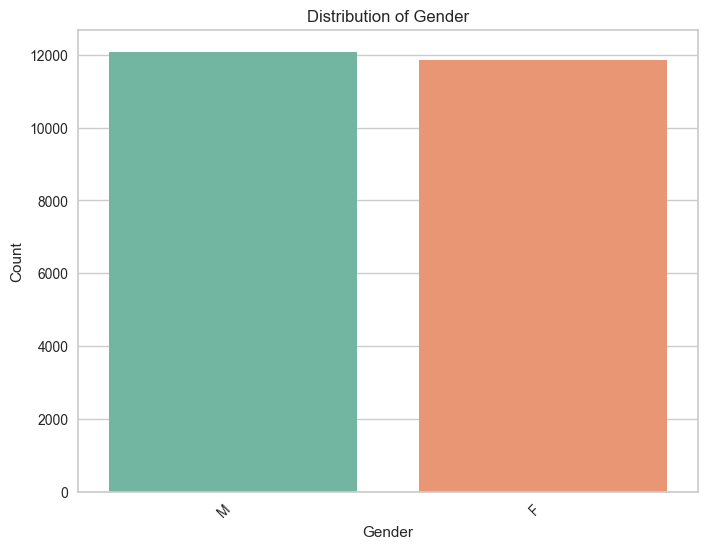

In [16]:
create_bar_plot(loan_amt_train_copy,'Gender')

#### Age

In [17]:
get_info(loan_amt_train_copy,'Age')

Description:
count    24000.000000
mean        40.058417
std         16.029209
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64


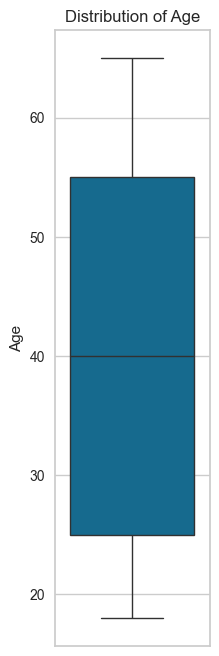

In [18]:
create_box_plot(loan_amt_train_copy,'Age')

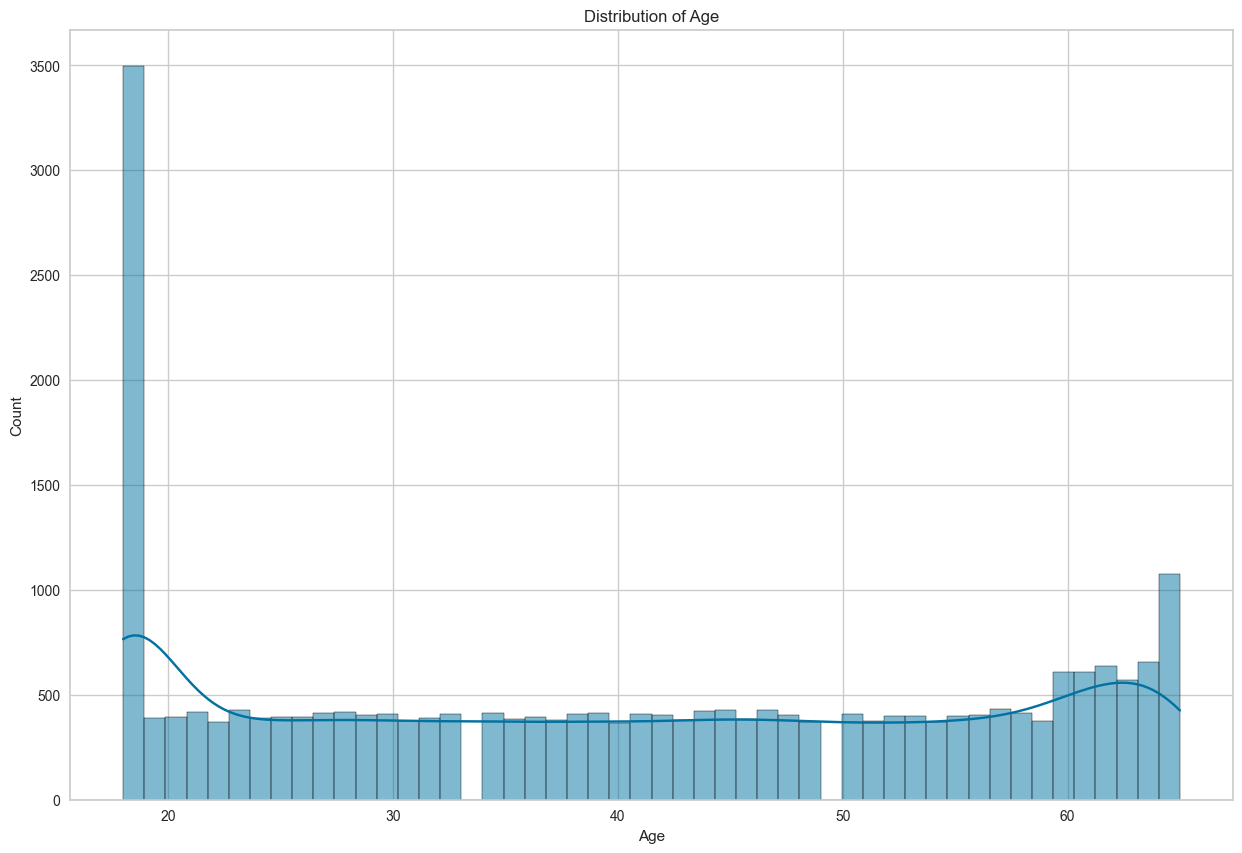

In [19]:
create_hist_plot(loan_amt_train_copy,'Age')

Interpretation:

- Age is not normal distribution.

- Mean and median is 40 years old.

#### Income (USD)

In [20]:
get_info(loan_amt_train_copy,'Income (USD)')

Description:
count     20352.000000
mean       2567.533530
std        1775.075442
min         378.760000
25%        1652.707500
50%        2229.965000
75%        3092.775000
max      122966.280000
Name: Income (USD), dtype: float64


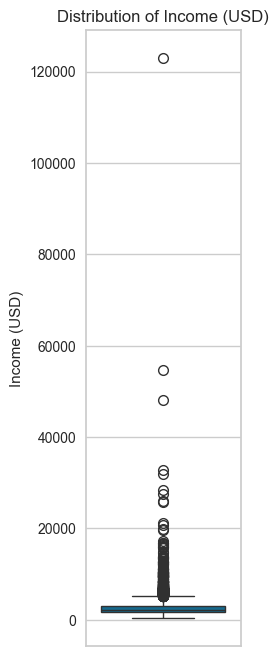

In [21]:
create_box_plot(loan_amt_train_copy,'Income (USD)')

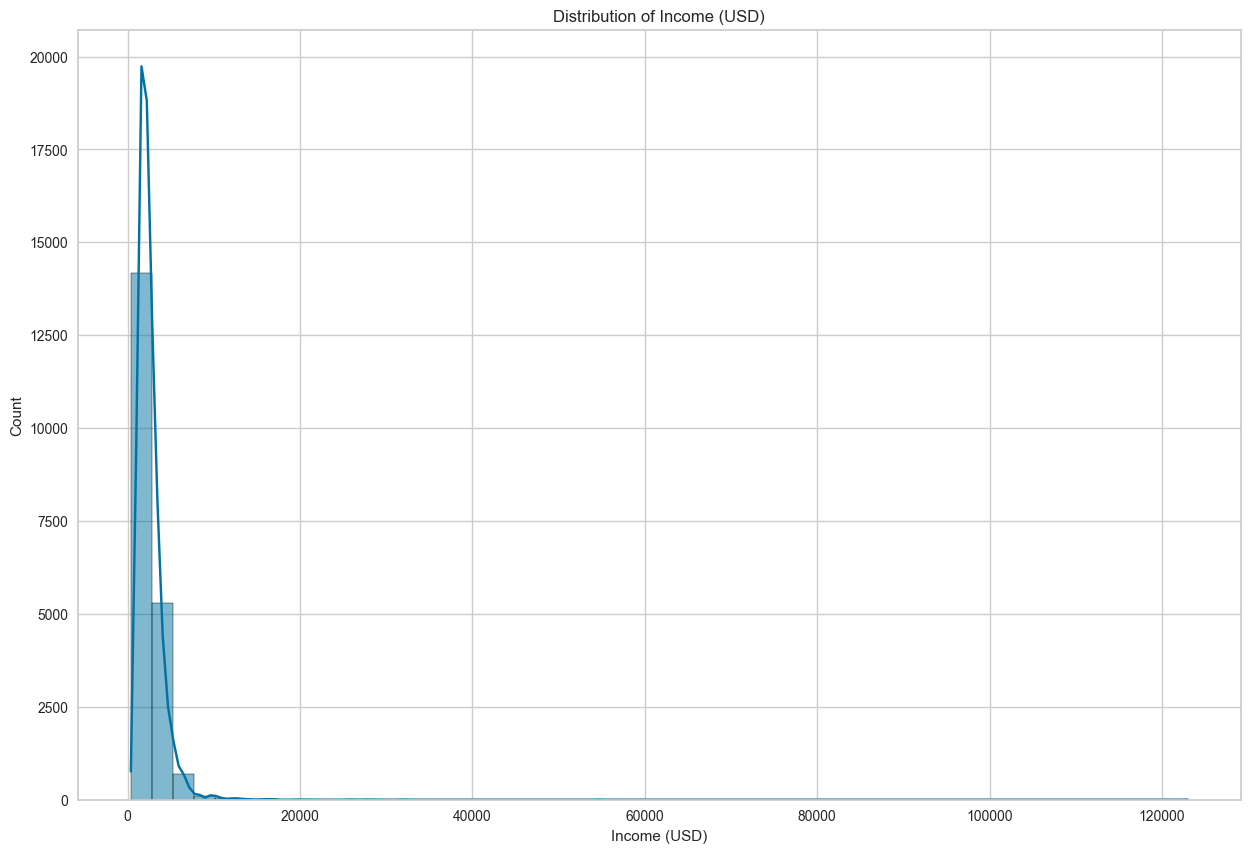

In [22]:
create_hist_plot(loan_amt_train_copy,'Income (USD)')

Interpretation:

- According to histogram Income is positive skewd.

- It has missing value.

- According to box plot it has lot of outliers.


#### Income Stability

In [23]:
get_info(loan_amt_train_copy,'Income Stability')

Description:
count     22676
unique        2
top         Low
freq      20617
Name: Income Stability, dtype: object
**************************************************
Frequency Table
                  Count  Percentage %
Income Stability                     
Low               20617         90.92
High               2059          9.08 


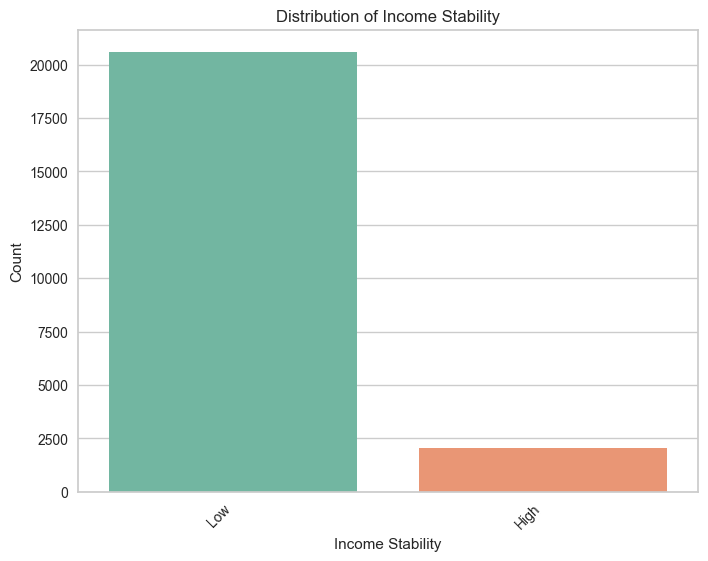

In [24]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

Interpretation:

- 90% of applicants have low Income Stability in odere word it means their income is inconsistent and subject to significant fluctuations.

#### Profession

In [25]:
get_info(loan_amt_train_copy,'Profession')


Description:
count       24000
unique          7
top       Working
freq        13509
Name: Profession, dtype: object
**************************************************
Frequency Table
                      Count  Percentage %
Profession                               
Working               13509         56.29
Commercial associate   6433         26.80
Pensioner              2193          9.14
State servant          1861          7.75
Unemployed                2          0.01
Businessman               1          0.00
Student                   1          0.00 


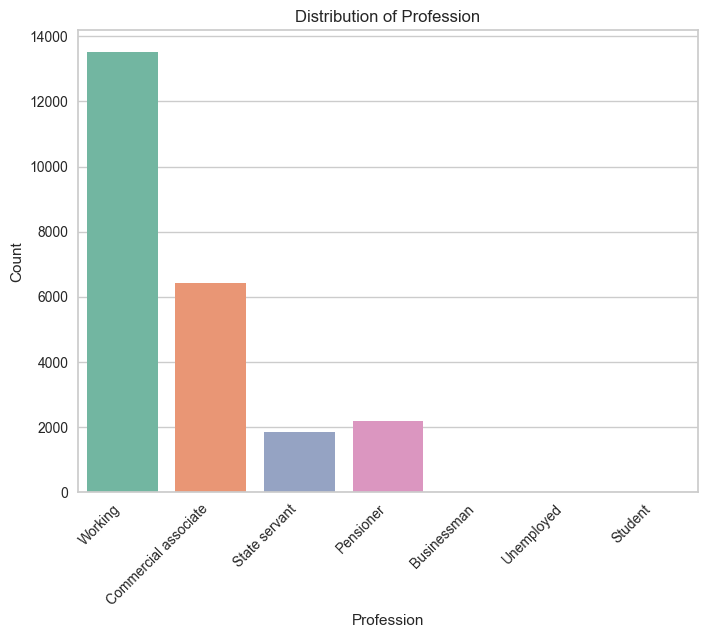

In [26]:
create_bar_plot(loan_amt_train_copy,'Profession')

Interpretation:

- Most applicants are currently working, and the most unrepresented category are the unemployed, businessman and student.

#### Type of Employment

In [27]:
get_info(loan_amt_test,'Type of Employment')

Description:
count         4502
unique          18
top       Laborers
freq          1083
Name: Type of Employment, dtype: object
**************************************************
Frequency Table
                       Count  Percentage %
Type of Employment                        
Laborers                1083         24.06
Sales staff              739         16.41
Core staff               625         13.88
Managers                 499         11.08
Drivers                  333          7.40
Accountants              283          6.29
High skill tech staff    263          5.84
Medicine staff           195          4.33
Cooking staff            120          2.67
Security staff           102          2.27
Private service staff     62          1.38
Cleaning staff            58          1.29
Low-skill Laborers        37          0.82
Secretaries               29          0.64
Waiters/barmen staff      27          0.60
HR staff                  17          0.38
IT staff                  17  

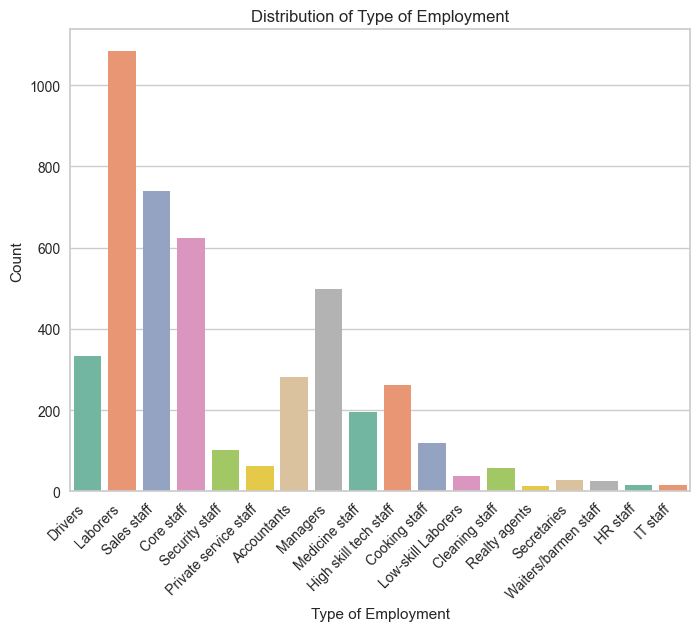

In [28]:
create_bar_plot(loan_amt_test,'Type of Employment')

Interpretation:

- The most represented employment are laborers, sales staff, core staff and managers.


#### Location

In [29]:
get_info(loan_amt_train_copy,'Location')

Description:
count          24000
unique             3
top       Semi-Urban
freq           17157
Name: Location, dtype: object
**************************************************
Frequency Table
            Count  Percentage %
Location                       
Semi-Urban  17157         71.49
Rural        4320         18.00
Urban        2523         10.51 


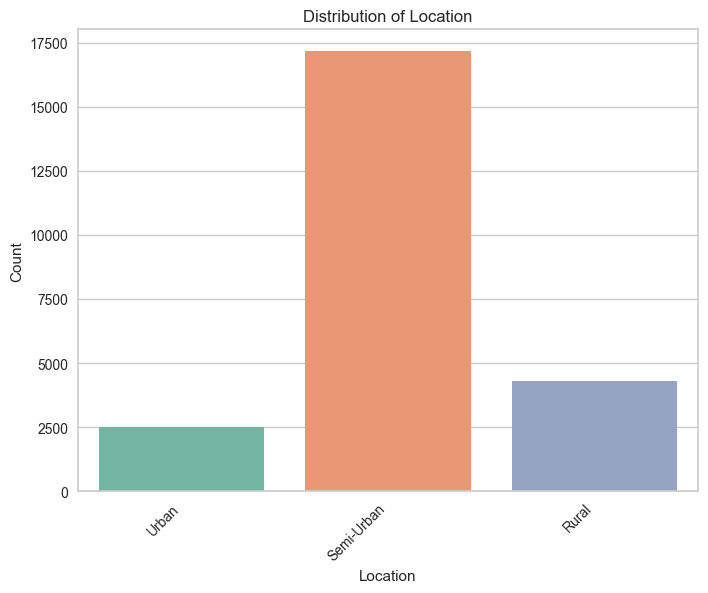

In [30]:
create_bar_plot(loan_amt_train_copy,'Location')

Interpretation:

- 7 out 10 applicants live in a semi-urban location

#### Loan Amount Request (USD)

In [31]:
get_info(loan_amt_train_copy,'Loan Amount Request (USD)')

Description:
count     24000.000000
mean      89075.615086
std       59637.687461
min        6048.240000
25%       41272.637500
50%       75326.655000
75%      120378.247500
max      621497.820000
Name: Loan Amount Request (USD), dtype: float64


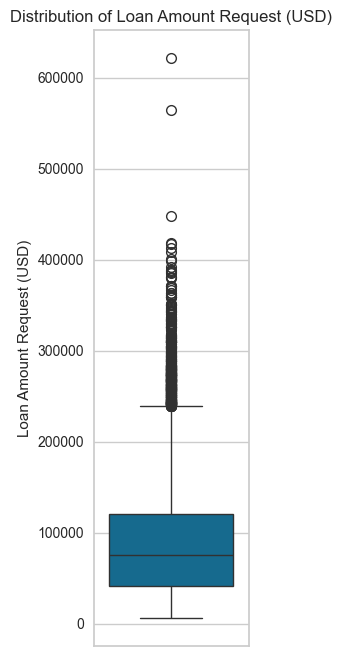

In [32]:
create_box_plot(loan_amt_train_copy,'Loan Amount Request (USD)')

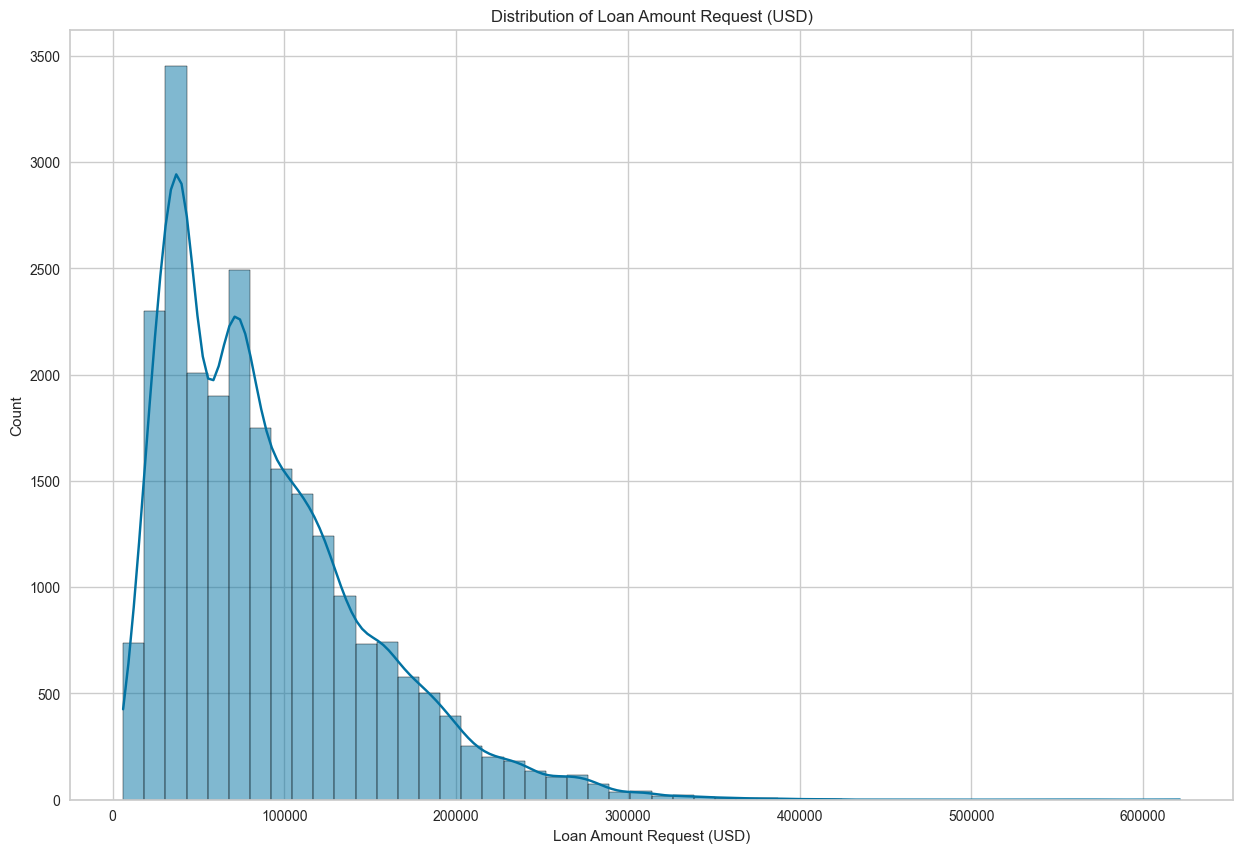

In [33]:
create_hist_plot(loan_amt_train_copy,'Loan Amount Request (USD)')

Interpretation:

- Loan Amount Request (USD) is right skewed.

- We have quite a number of outliers in the loan amount request.


#### Current Loan Expenses (USD)

In [34]:
get_info(loan_amt_train_copy,'Current Loan Expenses (USD)')

Description:
count    23872.000000
mean       401.409325
std        241.893479
min       -999.000000
25%        248.932500
50%        375.275000
75%        521.215000
max       3419.660000
Name: Current Loan Expenses (USD), dtype: float64


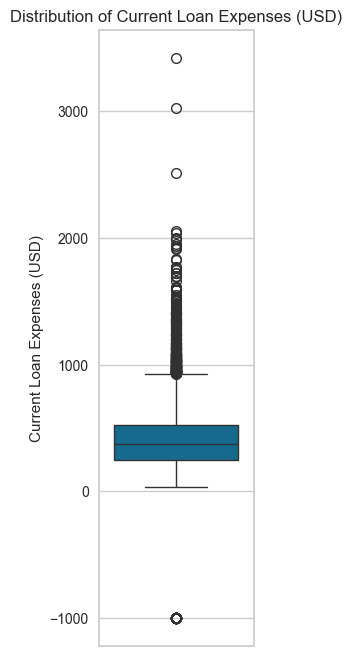

In [35]:
create_box_plot(loan_amt_train_copy,'Current Loan Expenses (USD)')

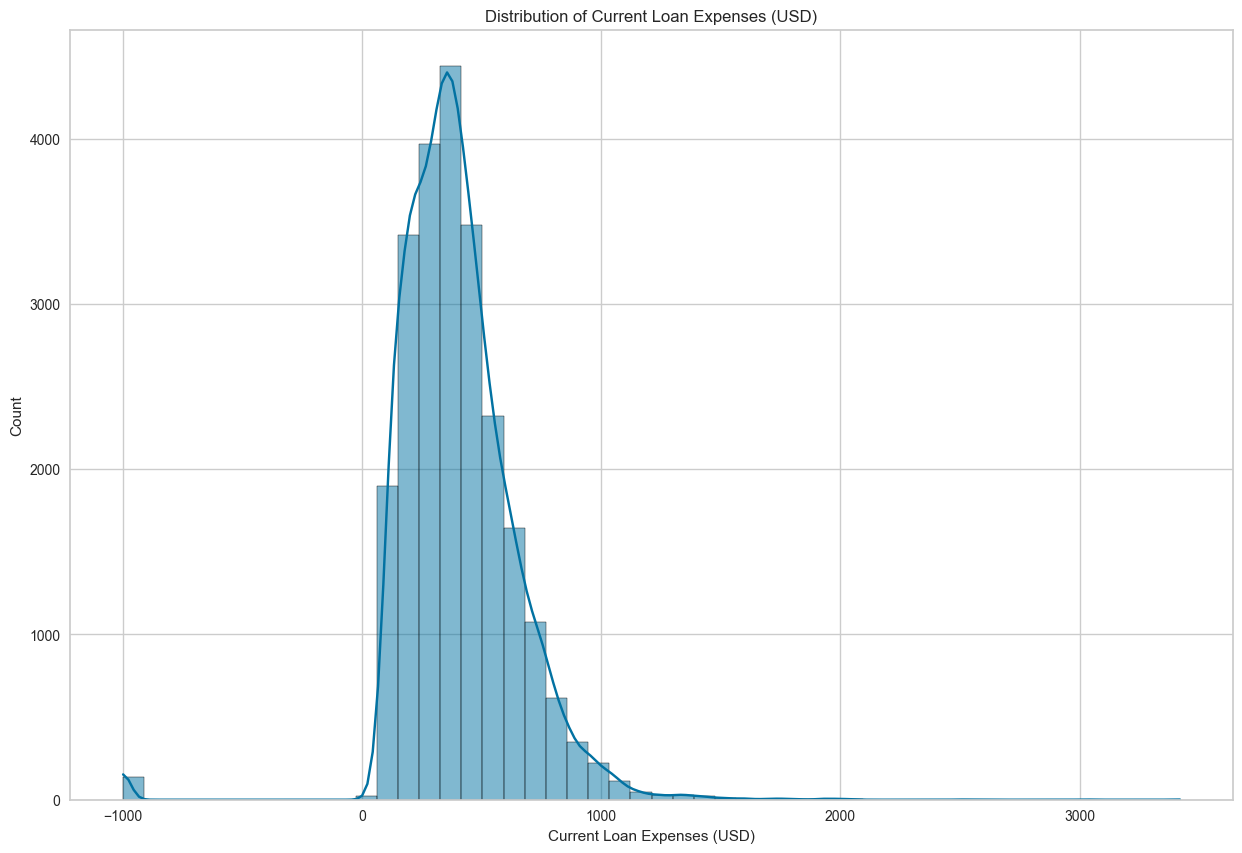

In [36]:
create_hist_plot(loan_amt_train_copy,'Current Loan Expenses (USD)')

Interpretation:

- The mean current loan expenses is $401.40

- We have also some outliers.

- The current loan expenses is positively skewed.

- min is -999.000000


In [37]:
get_info(loan_amt_train_copy,'Expense Type 1')

Description:
count     24000
unique        2
top           N
freq      15361
Name: Expense Type 1, dtype: object
**************************************************
Frequency Table
                Count  Percentage %
Expense Type 1                     
N               15361          64.0
Y                8639          36.0 


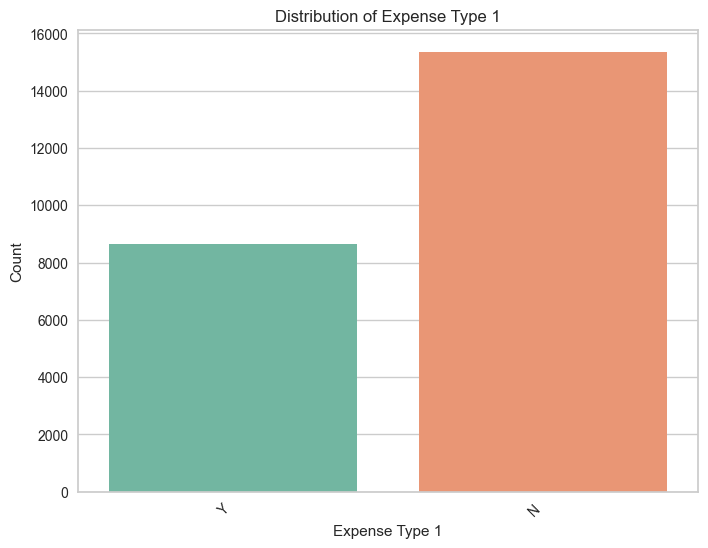

In [38]:
create_bar_plot(loan_amt_train_copy,'Expense Type 1')

Interpretation:

- More than half of applicants don't have the expenses type 1 on their loan.

#### Expense Type 2

In [39]:
get_info(loan_amt_train_copy,'Expense Type 2')

Description:
count     24000
unique        2
top           Y
freq      16116
Name: Expense Type 2, dtype: object
**************************************************
Frequency Table
                Count  Percentage %
Expense Type 2                     
Y               16116         67.15
N                7884         32.85 


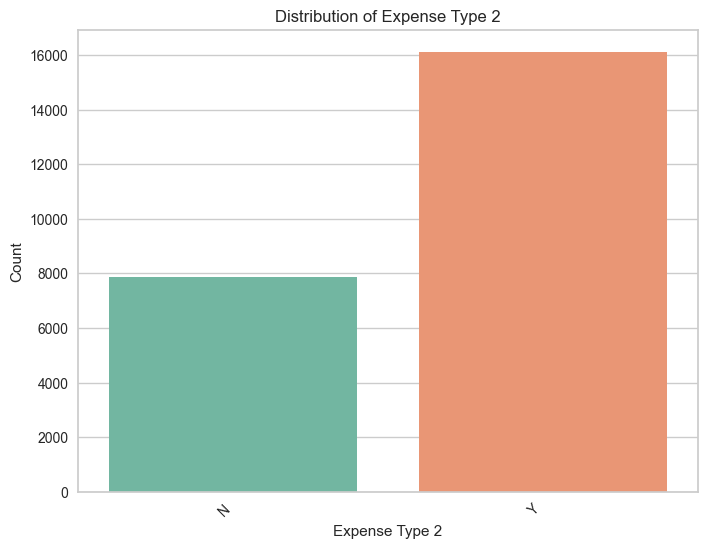

In [40]:
create_bar_plot(loan_amt_train_copy,'Expense Type 2')

Interpretation:

- More than half of applicants don't have the expenses type 1 on their loan.

#### Dependents

In [41]:
get_info(loan_amt_train_copy,'Dependents')

Description:
count    21983.000000
mean         2.250512
std          0.947379
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Dependents, dtype: float64
**************************************************
Frequency Table
            Count  Percentage %
Dependents                     
2.0         10471         47.63
3.0          4568         20.78
1.0          4447         20.23
4.0          2160          9.83
5.0           293          1.33
6.0            37          0.17
7.0             5          0.02
8.0             1          0.00
10.0            1          0.00 


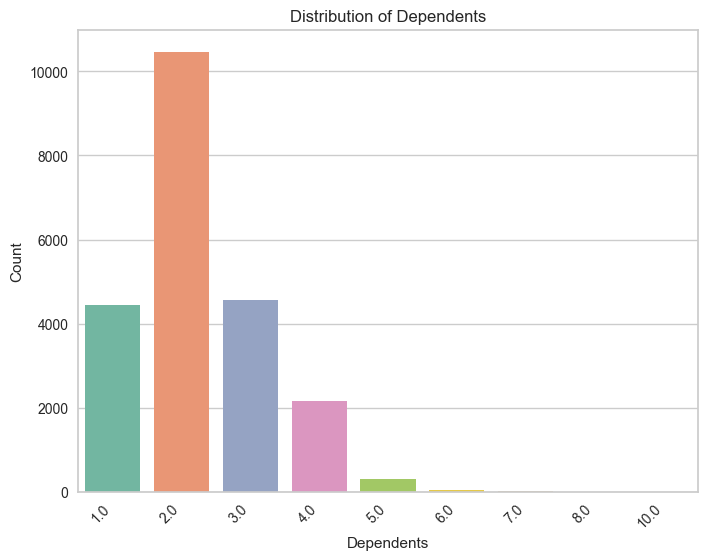

In [42]:
create_bar_plot(loan_amt_train_copy,'Dependents')

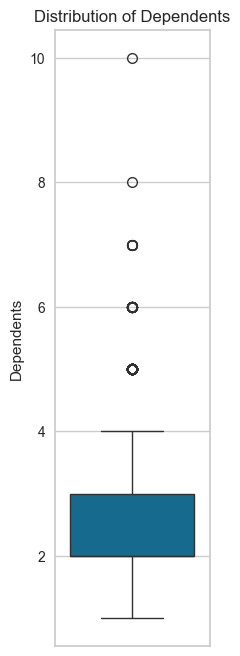

In [43]:
create_box_plot(loan_amt_train_copy,'Dependents')

Interpretation:

- Most applicants have 2 dependents.


#### Credit Score

In [44]:
get_info(loan_amt_train_copy,'Credit Score')

Description:
count    22623.000000
mean       739.726632
std         72.271823
min        580.000000
25%        681.225000
50%        739.880000
75%        799.090000
max        896.260000
Name: Credit Score, dtype: float64


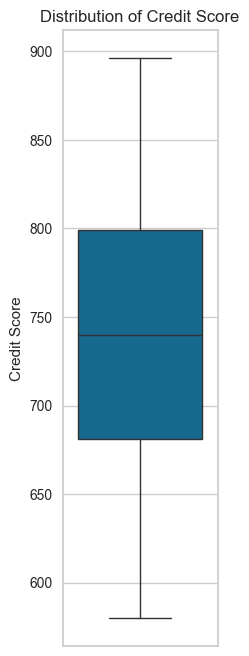

In [45]:
create_box_plot(loan_amt_train_copy,'Credit Score')

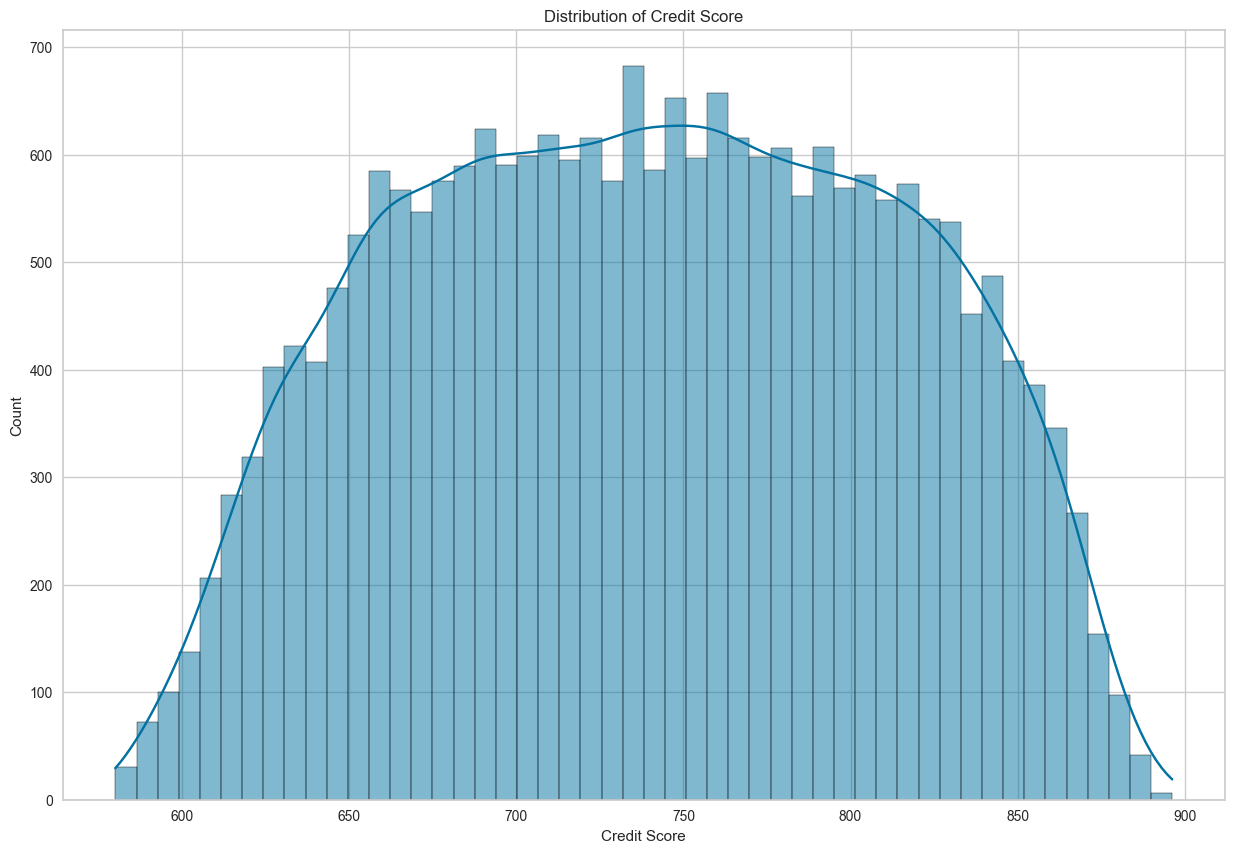

In [46]:
create_hist_plot(loan_amt_train_copy,'Credit Score')

Interpretation:

- The mean and median of applicants's credit score is 739.

- The credit score does not seems to be skewed but it is not normally distributed

#### No. of Defaults

In [47]:
get_info(loan_amt_train_copy,'No. of Defaults')

Description:
count    24000.000000
mean         0.193875
std          0.395340
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: No. of Defaults, dtype: float64
**************************************************
Frequency Table
                 Count  Percentage %
No. of Defaults                     
0                19347         80.61
1                 4653         19.39 


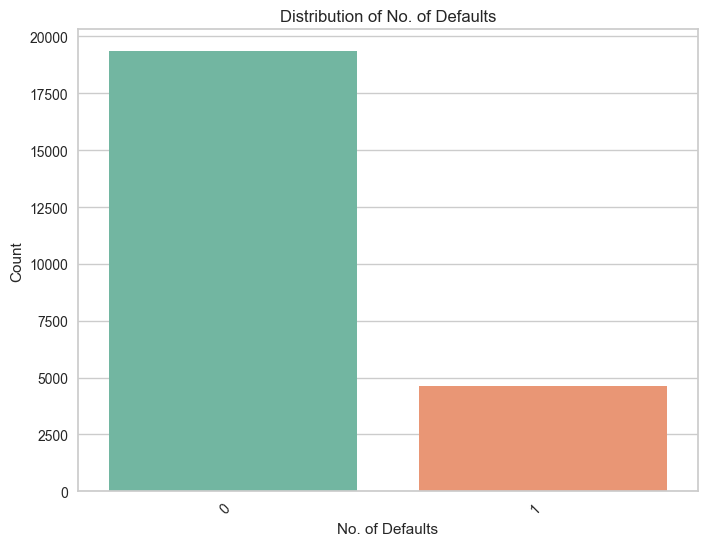

In [48]:
create_bar_plot(loan_amt_train_copy,'No. of Defaults')

Interpretation:

- 8 of 10 people don't have a any loan defaulted.

#### Has Active Credit Card

In [49]:
get_info(loan_amt_train_copy,'Has Active Credit Card')

Description:
count      22746
unique         3
top       Active
freq        7799
Name: Has Active Credit Card, dtype: object
**************************************************
Frequency Table
                        Count  Percentage %
Has Active Credit Card                     
Active                   7799         34.29
Inactive                 7620         33.50
Unpossessed              7327         32.21 


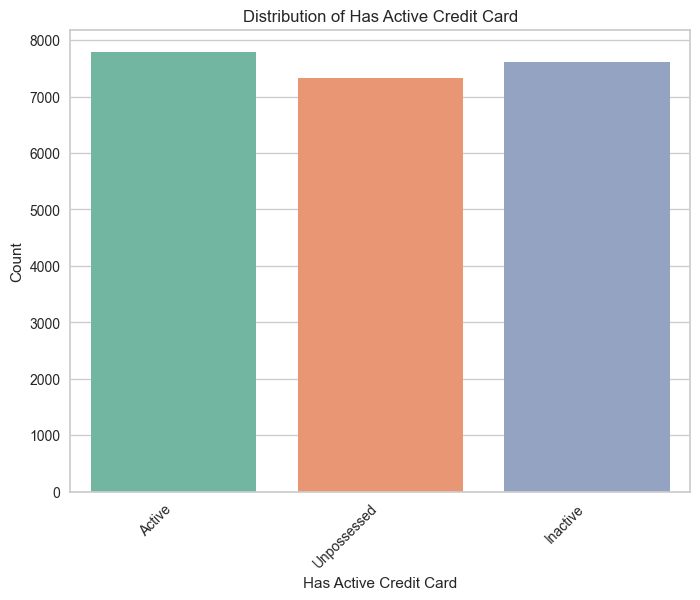

In [50]:
create_bar_plot(loan_amt_train_copy,'Has Active Credit Card')

Interpretation:

- We have almost an equal amount of people with an active, inactive and unpossessed credit card.

#### Property Age

In [51]:
get_info(loan_amt_train_copy,'Property Age')

Description:
count    20149.000000
mean         7.030366
std          4.864649
min          1.036988
25%          4.525777
50%          6.108419
75%          8.471047
max        336.663326
Name: Property Age, dtype: float64
**************************************************


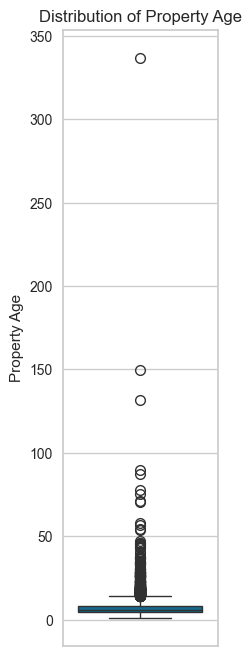

In [52]:
create_box_plot(loan_amt_train_copy,'Property Age')

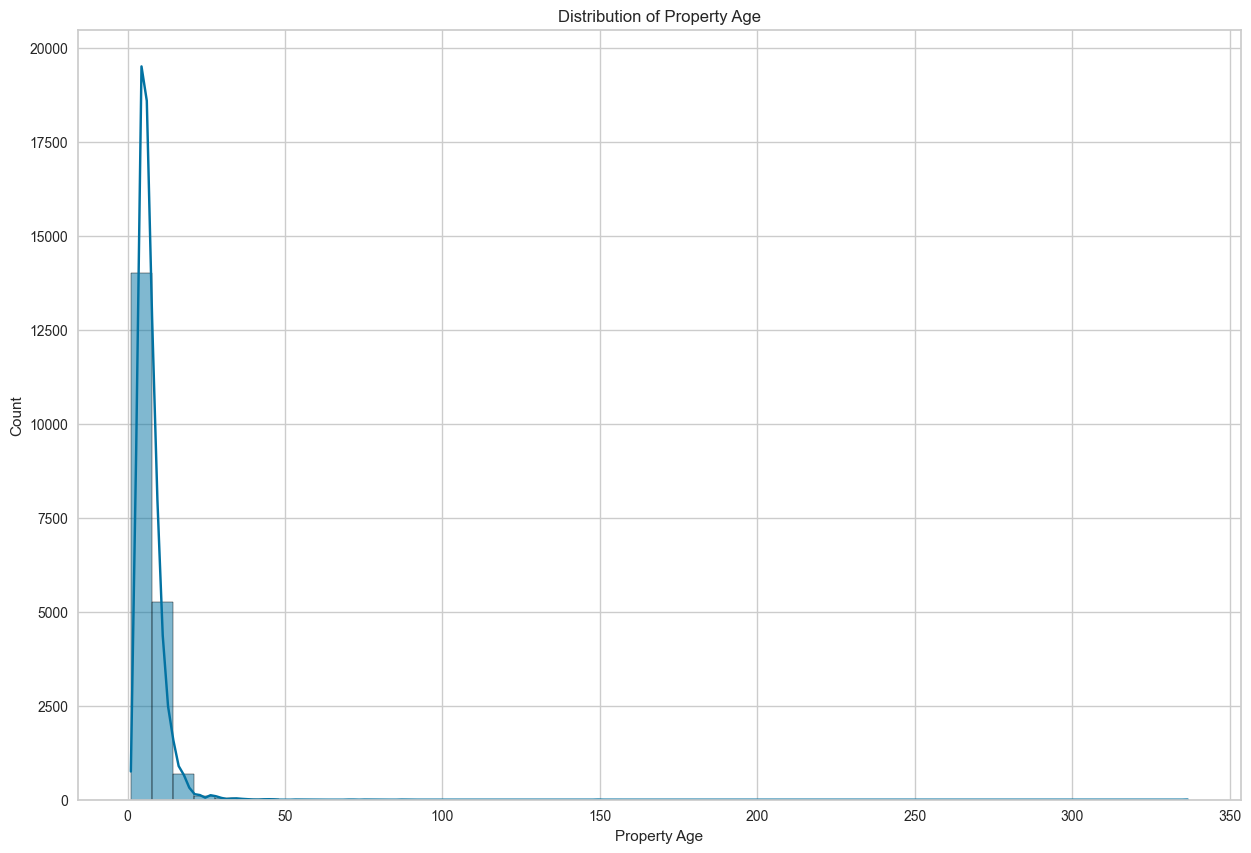

In [53]:
create_hist_plot(loan_amt_train_copy,'Property Age')

Interpretation:

- The property age distribution is positively skewed

#### Property Type

In [54]:
get_info(loan_amt_train_copy,'Property Type')

Description:
count    24000.000000
mean         2.463708
std          1.121005
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Property Type, dtype: float64
**************************************************
Frequency Table
               Count  Percentage %
Property Type                     
1               6304         26.27
2               6054         25.22
3               5851         24.38
4               5791         24.13 


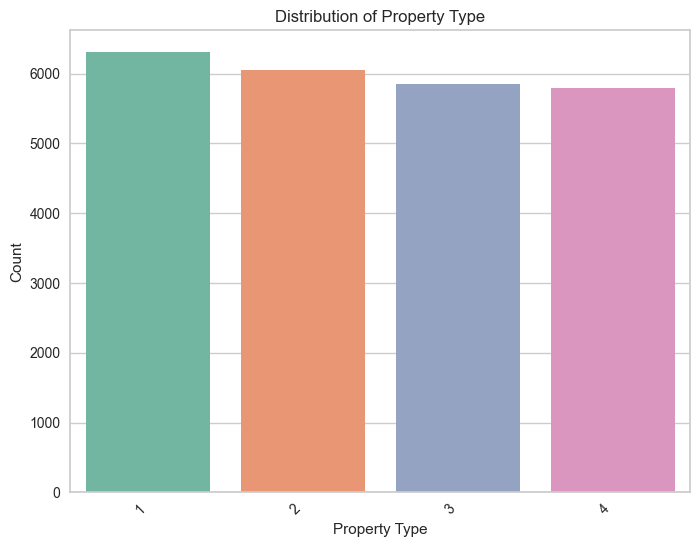

In [55]:
create_bar_plot(loan_amt_train_copy,'Property Type')

Interpretation:

- We have almost an equal amount of property types, each with 25%

#### Property Location

In [56]:
get_info(loan_amt_train_copy,'Property Location')

Description:
count          23727
unique             3
top       Semi-Urban
freq            8277
Name: Property Location, dtype: object
**************************************************
Frequency Table
                   Count  Percentage %
Property Location                     
Semi-Urban          8277         34.88
Rural               8060         33.97
Urban               7390         31.15 


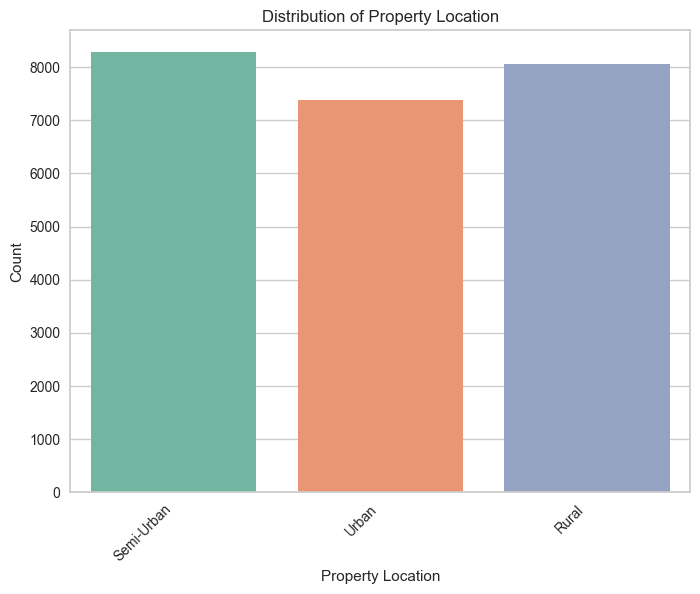

In [57]:
create_bar_plot(loan_amt_train_copy,'Property Location')

Interpretation:

- All the 3 property location are almost equally distributed at around 33%

#### Co-Applicant

In [58]:
get_info(loan_amt_train_copy,'Co-Applicant')

Description:
count    24000.000000
mean        -4.686333
std         74.227397
min       -999.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Co-Applicant, dtype: float64
**************************************************
Frequency Table
              Count  Percentage %
Co-Applicant                     
 1            20395         84.98
 0             3472         14.47
-999            133          0.55 


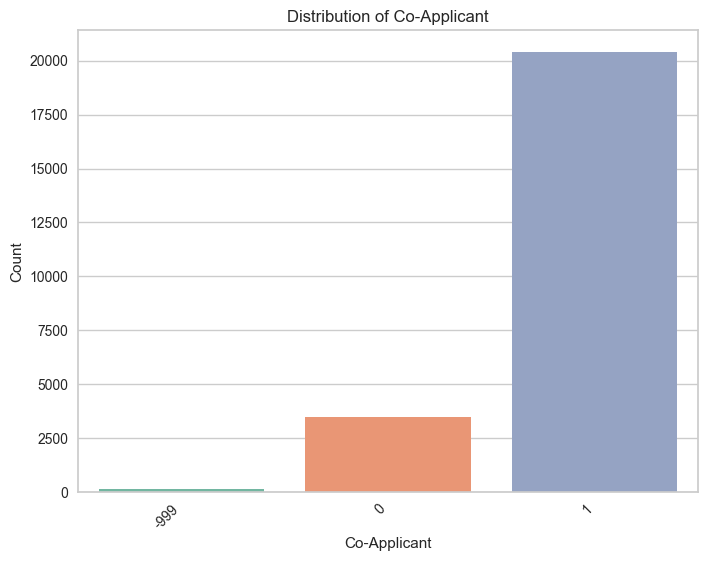

In [59]:
create_bar_plot(loan_amt_train_copy,'Co-Applicant')

Interpretation:

- Most of applicants have a co-applicants (~85%)

- 14% of applicants don't have a co-applicant



#### 'Property Price'

In [60]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

get_info(loan_amt_train_copy,'Property Price')

Description:
count     24000.000
mean     132018.284
std       93566.244
min        -999.000
25%       60793.940
50%      110168.710
75%      179084.020
max     1077966.730
Name: Property Price, dtype: float64


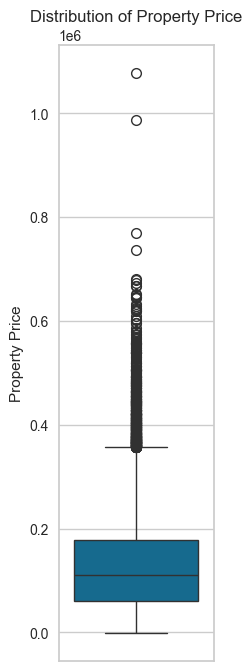

In [61]:
create_box_plot(loan_amt_train_copy,'Property Price')

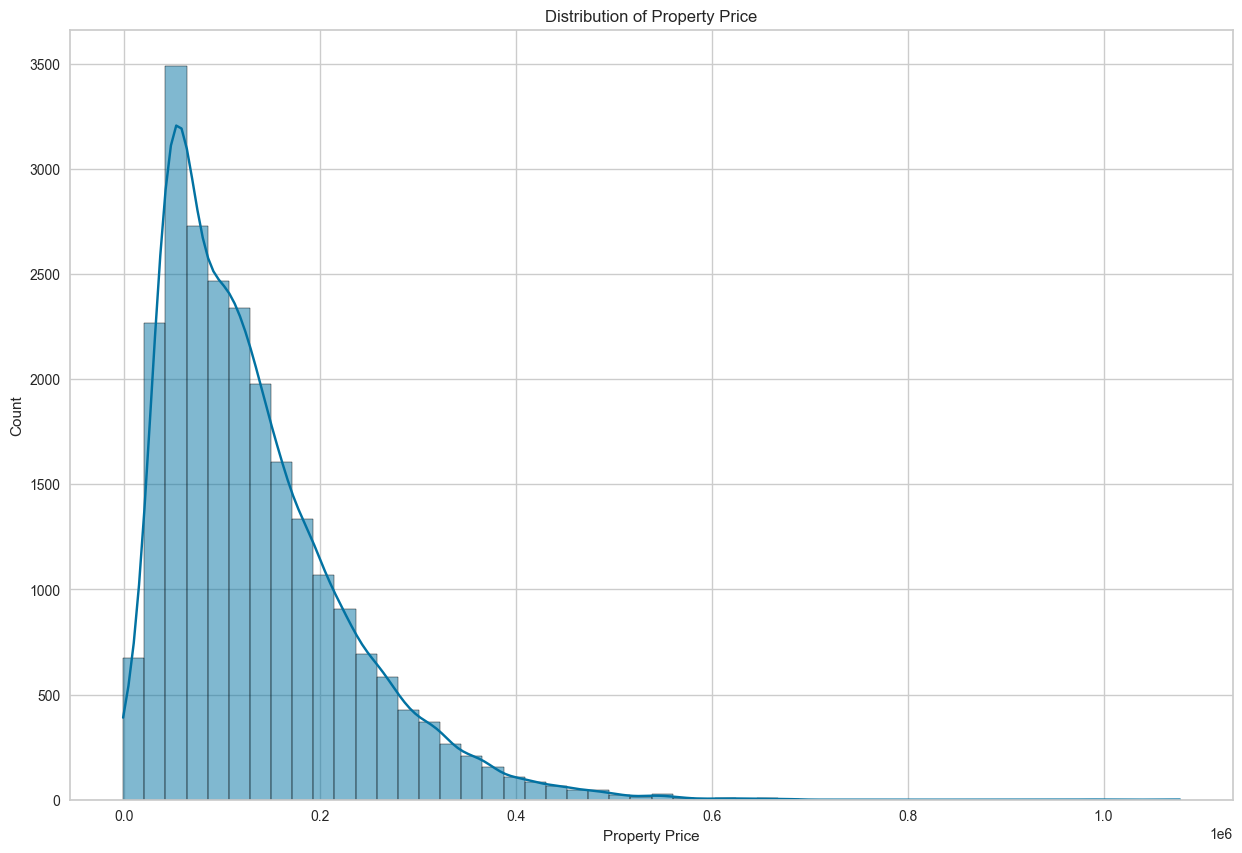

In [62]:
create_hist_plot(loan_amt_train_copy,'Property Price')

Interpretation:

- The median property price is $110168.710

- We have quite a number of outliers.

- The distribution of the property price is skewed to the right.

#### 'Loan Sanction Amount (USD)'

In [63]:
get_info(loan_amt_train_copy,'Loan Sanction Amount (USD)')

Description:
count    23725.000
mean     47680.600
std      48224.125
min       -999.000
25%          0.000
50%      35273.020
75%      74217.940
max     395368.740
Name: Loan Sanction Amount (USD), dtype: float64


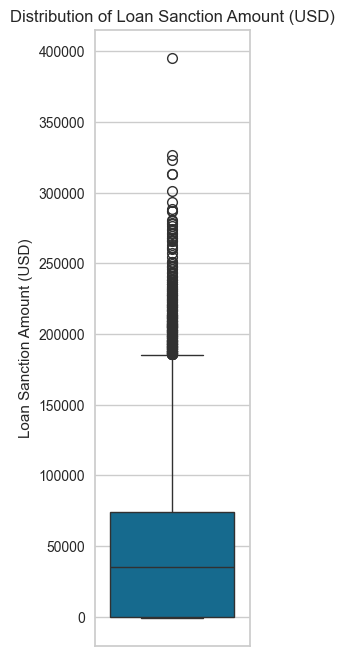

In [64]:
create_box_plot(loan_amt_train_copy,'Loan Sanction Amount (USD)')

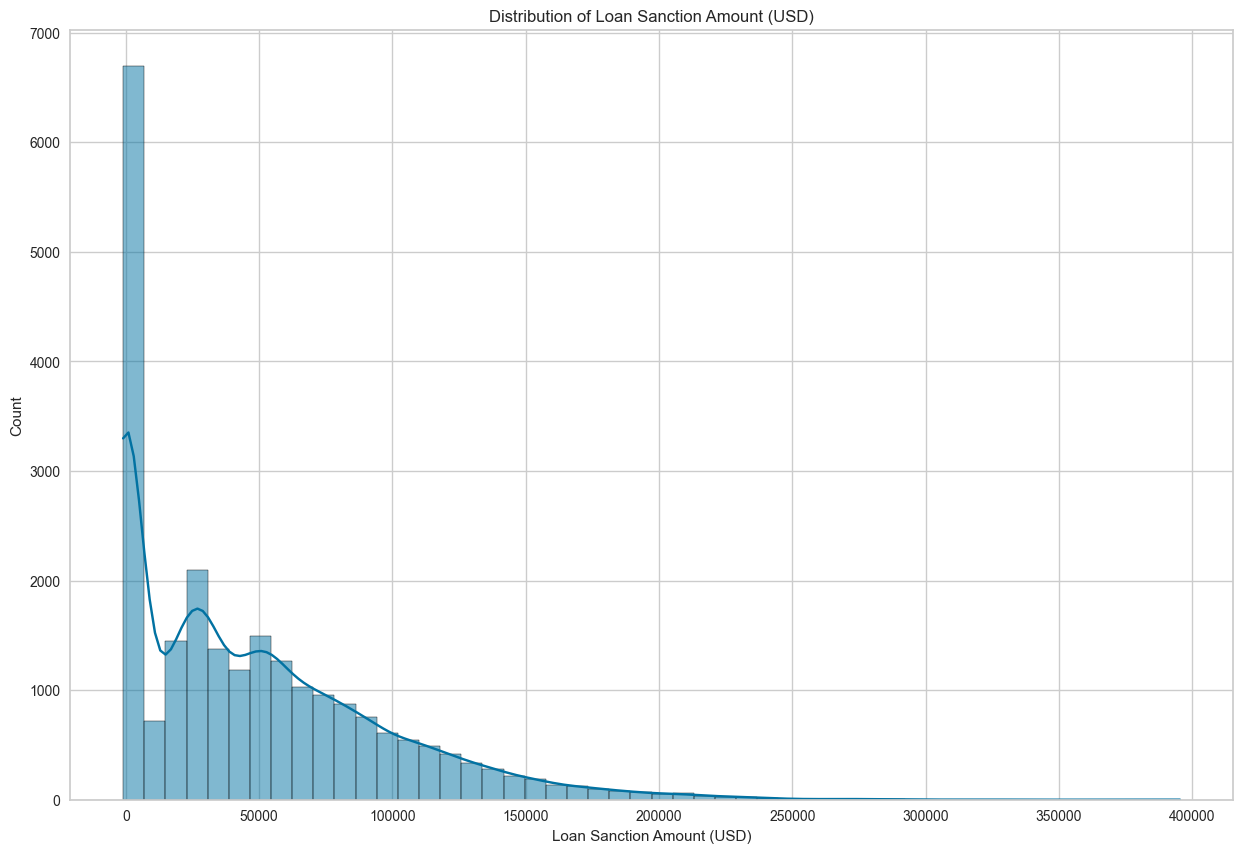

In [65]:
create_hist_plot(loan_amt_train_copy,'Loan Sanction Amount (USD)')

Interpretation:

- The median loan sanction amount is $35273.020

- We have quite a number of outliers.

- The distribution of the loan sanction amount is skewed to the right.


### 2.3 Bivariate Analysis

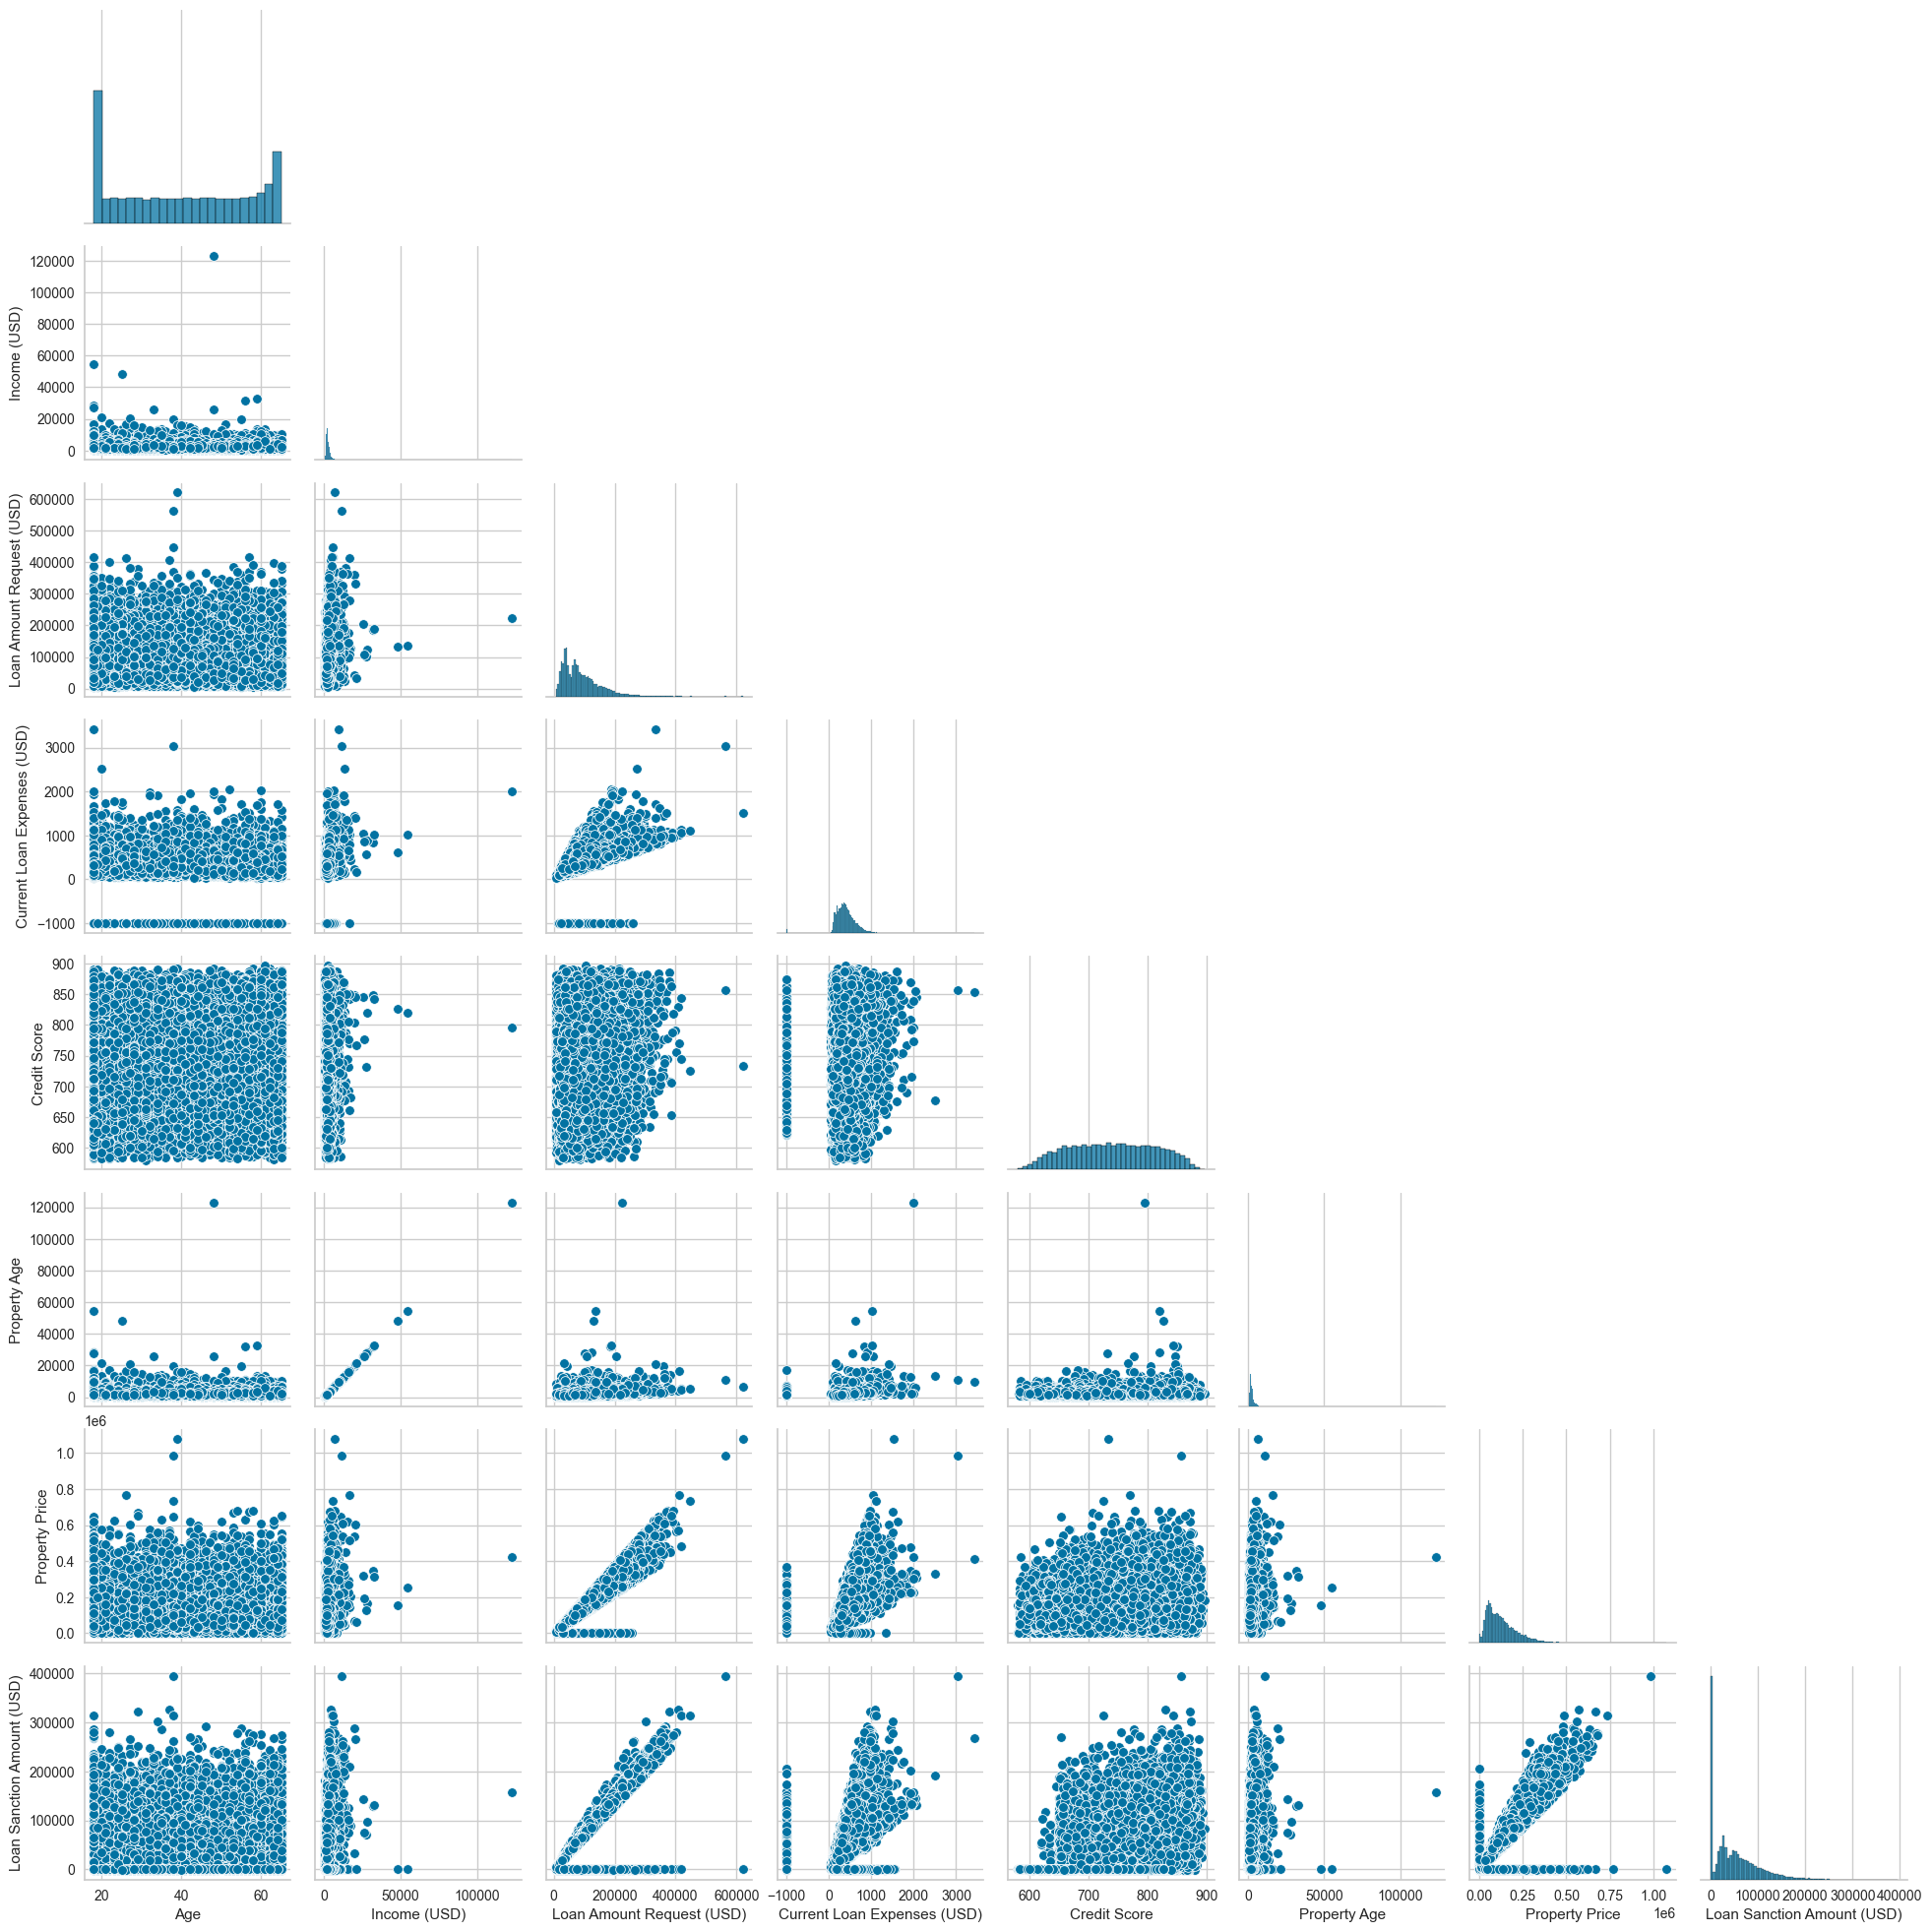

In [66]:
sns.pairplot(loan_amt_train_copy[['Age','Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)',
                                  'Credit Score','Property Age','Property Price','Loan Sanction Amount (USD)']],
                                  corner=True)

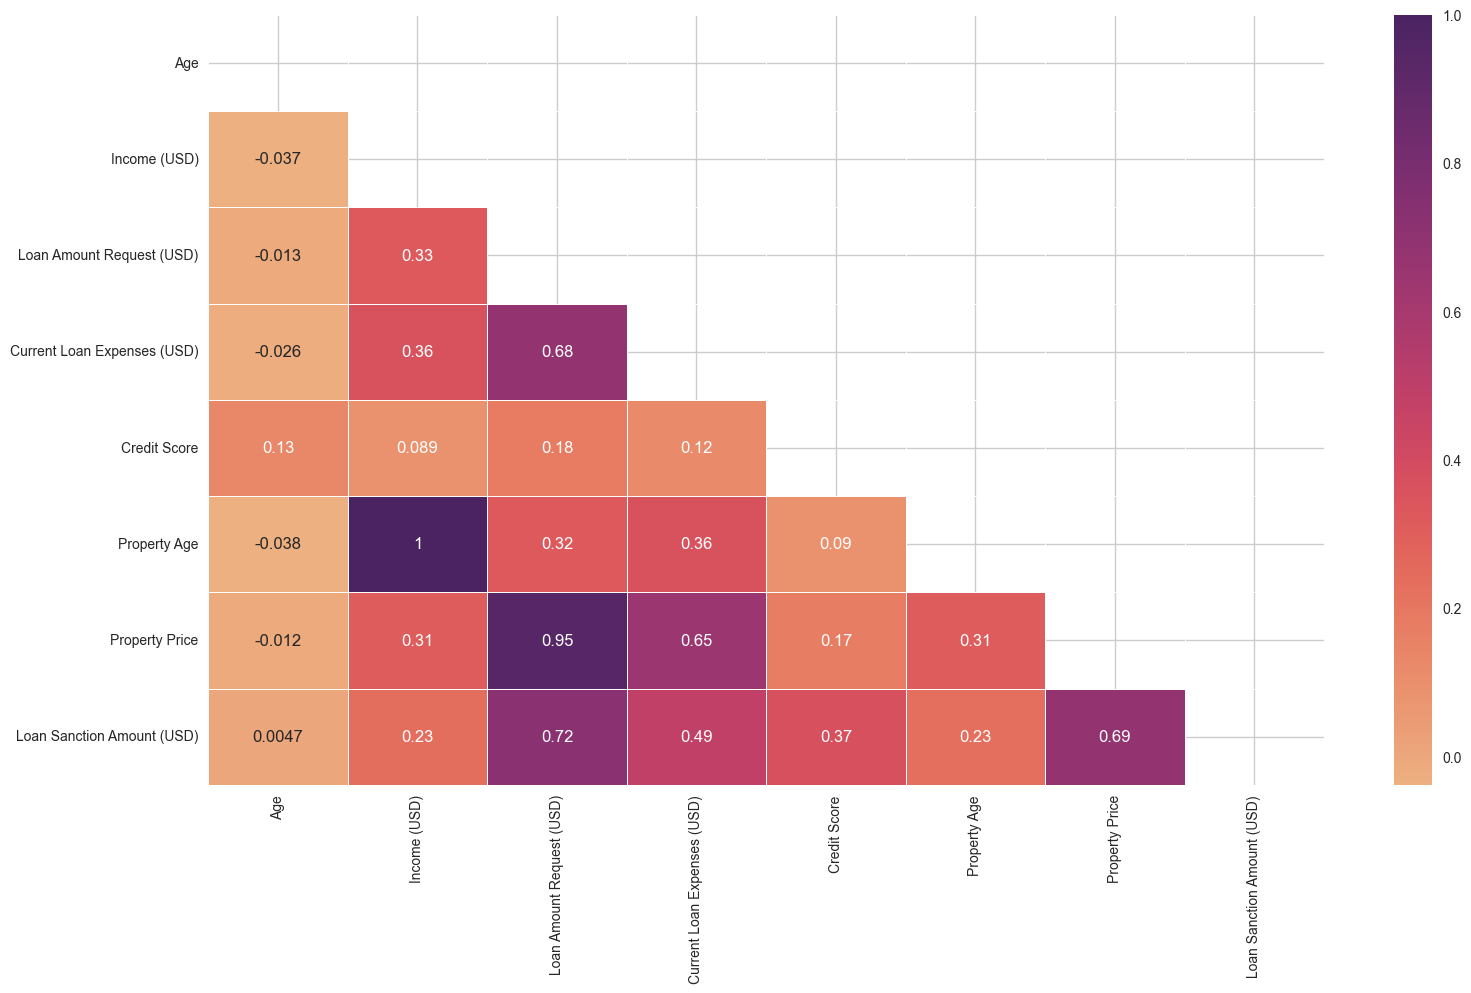

In [67]:
loan_amt_train_copy_corr = loan_amt_train_copy[['Age','Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)',
                                  'Credit Score','Property Age','Property Price','Loan Sanction Amount (USD)']].corr()
mask = np.zeros_like(loan_amt_train_copy_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(loan_amt_train_copy_corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()


Interpretation:

- There is a positive correlation between the loan amount request and the current loan expenses.

- Income is highly correlated with Property age.

- Loan Amount Request is highly correlated with Property Price

- Loan Amount Request is highly correlated with Loan Sanction Amount.

- Current Loan Expenses is correlated with Property Price

- Current Loan Expenses is correlated with Loan Sanction Amount

- Loan Sanction Amount is highly correlated with Property Price.





### 2.4 Features vs Target Variable

In [68]:
objetc_feature_1 = train_df.select_dtypes(include=['object']).columns.tolist()
objetc_feature_2 = ['Dependents','No. of Defaults','Property Type','Co-Applicant']
objetc_feature = objetc_feature_1 + objetc_feature_2
objetc_feature

['Customer ID',
 'Name',
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location',
 'Dependents',
 'No. of Defaults',
 'Property Type',
 'Co-Applicant']

In [69]:
categorical_col = [
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location',
 'Dependents',
 'No. of Defaults',
 'Property Type',
 'Co-Applicant']

fig , ax = plt.subplots(7,2,figsize =(20,80),dpi=180) 
ax = ax.flatten()  # Flatten the axes array to easily loop over it
for index , col in enumerate(categorical_col):
   

    sns.boxplot(x=loan_amt_train_copy[col] , y=loan_amt_train_copy['Loan Sanction Amount (USD)'],ax=ax[index])
    ax[index].set_xlabel(col)
    ax[index].set_ylabel('Loan Sanction Amount (USD)')
    ax[index].tick_params(axis='x', rotation=45, labelsize=10)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()    


Interpretation:

- People with high income stability were given a high loan sanction amount.

- Managers, HR staff and accounts received a median loan sanction amount of $5000.

- People who live in urban area received the highest loan sanction amount

## 🛠️ Data Preprocessing  

1. Feature drop: 
- Customer ID
- Name
- Property ID


2. One hot encoding:
- Gender
- Type of Employment
- Profession
- Expense Type 1
- Expense Type 2
- Dependents
- Has Active Credit Card
- No. of Defaults
- Property Type
- Co-Applicant
- Property Location

3. Missing value:
- Gender (Mode Imputation)
- Income (Median Imputation : Right-skewed distributions with outliers.)
- Income Stability (Mode Imputation)
- Type of Employment (Mode Imputation)
- Current Loan Expenses (Median Imputation )
- Dependents (Mode Imputation)
- Has Active Credit Card (Mode Imputation)
- Property Age (Median Imputation )
- Property Location (Mode Imputation)
- Loan Sanction Amount (Drop the rows)


4. Outliers handler

- Income
- Loan Amount Request 
- Current Loan Expenses
- Dependents
- Property Age
- Property Price

5. Normalization

- Income
- Age
- Loan Amount Request 
- Current Loan Expenses
- Credit Score
- Property Age
- Property Price
- Loan Sanction Amount 

6. Fix skewness

- Income
- Loan Amount Request 
- Current Loan Expenses
- Property Age
- Property Price


📍 Let's create a pipeline for data preprocessing. Defining a pipeline can be useful as we plan to run the same set of operations repeatedly across multiple features or datasets. 

In [70]:
# Feature Drop

class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['Customer ID','Name','Type of Employment','Property ID']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe for drop feature")
            return df

In [71]:
class OnehotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft=None):
        if one_hot_enc_ft is None:
            one_hot_enc_ft = [
                'Gender', 'Profession', 'Location', 'Expense Type 1', 
                'Expense Type 2', 'Has Active Credit Card', 'Property Location', 
                'Income Stability'
            ]
        self.one_hot_enc_ft = one_hot_enc_ft

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        # Check if all features for one-hot encoding are present in the DataFrame
        if not set(self.one_hot_enc_ft).issubset(df.columns):
            raise ValueError("One or more features are not in the dataframe")
        
        # One-hot encode the specified features
        encoder = OneHotEncoder()
        one_hot_encoded = encoder.fit_transform(df[self.one_hot_enc_ft])
        feat_names_one_hot_enc = encoder.get_feature_names_out(self.one_hot_enc_ft)
        
        # Create a DataFrame for the one-hot encoded features
        one_hot_enc_df = pd.DataFrame(one_hot_encoded.toarray(), columns=feat_names_one_hot_enc, index=df.index)
        
        # Drop the original one-hot encoded columns and concatenate with the rest
        df_remaining = df.drop(columns=self.one_hot_enc_ft)
        df_concat = pd.concat([one_hot_enc_df, df_remaining], axis=1)
        
        return df_concat


In [72]:
# Missing Value

class MissingValueImputation(BaseEstimator,TransformerMixin):
    def __init__(self, mode_imputed_ft = ['Gender','Income Stability','Dependents','Has Active Credit Card','Property Location'], 
                 median_imputed_ft = ['Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age']):
       self.mode_imputed_ft=mode_imputed_ft
       self.median_imputed_ft=median_imputed_ft

    def fit( self, df) :
        return self
    
    def transform (self , df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):

        # Drop rows where 'Loan Sanction Amount (USD)' is missing
            df.dropna(subset=['Loan Sanction Amount (USD)'],inplace=True,axis=0)

        # Impute continuous features with the mean
        for col in self.median_imputed_ft:
           if col in df.columns :
            df[col] = df[col].fillna(df[col].median())

        # Impute categorical features with the mode
        for col in self.mode_imputed_ft:
           if col in df.columns:
              df[col]=df[col].fillna(df[col].mode()[0])

        return df 

In [73]:
# Outliers handler

class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Property Age', 'Property Price']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            Q1 = df[self.feat_with_outliers].quantile(.25)
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe Outliers")
            return df

In [74]:
# Normalization

class Normalizer(BaseEstimator,TransformerMixin):
    def __init__(self,normalizer_feature=['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age', 'Property Price']):
        self.normalizer_feature=normalizer_feature

    def fit(self,df):
        return self

    def transform(self,df):
        if(set(self.normalizer_feature).issubset(df.columns)):
            min_max = MinMaxScaler()
            df[self.normalizer_feature]= min_max.fit_transform(df[self.normalizer_feature]) # Applied to all selected features simultaneously to scale them
            return df
        else:
            print("One or more features are not in the dataframe for normalization")
            return df

In [75]:
# Fix skewness
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Property Age']):
        self.col_with_skewness = col_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.col_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.col_with_skewness] = np.cbrt(df[self.col_with_skewness])
            return df
        else:
            print('One or more skewed columns are not found for skewness')
            return df

In [76]:
# Remove less frequent professions

class DropUncommonProfession(BaseEstimator, TransformerMixin):
    def __init__(self,profession_list = ['Student','Unemployed','Businessman']):
        self.profession_list = profession_list
    def fit(self,df):
        return self
    def transform(self,df):
        if ('Profession' in df.columns):
            # only keep the professions that are not in the profession_list
            df = df[~df['Profession'].isin(self.profession_list)]
            return df
        else:
            print("Profession feature is not in the dataframe for professions")
            return df

In [77]:
# -999 Value imputer

class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_999_val=['Co-Applicant', 'Current Loan Expenses (USD)', 'Loan Sanction Amount (USD)', 'Property Price']):
        self.feat_with_999_val = feat_with_999_val
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_999_val).issubset(df.columns)):
            for col in self.feat_with_999_val:
                # replace any occurance of -999.000 with 0
                df[col].replace(-999.000,0,inplace=True,regex=True) # Applied individually to handle specific placeholder values in each column.
            return df
        else:
            print("One or more features are not in the dataframe for -999")
            return df

In [78]:
def data_preprocessing_pipeline(df):
    pipeline = Pipeline([
        ('outlier remover', OutlierImputer()),
        ('drop uncommon profession', DropUncommonProfession()),
        ('missing value imputer', MissingValueImputation()),
        ('drop features', DropFeatures()),
        ('-999 value imputer', ValueImputer()),
        ('skewness handler', SkewnessHandler()),
        ('min max scaler', Normalizer()),
        ('one hot encoder', OnehotEncoder())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [79]:
pd.options.mode.chained_assignment = None
loan_amt_train_copy_prep = data_preprocessing_pipeline(loan_amt_train_copy)
loan_amt_train_copy_prep.head(3)

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_12198/2263676804.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(-999.000,0,inplace=True,regex=True) # Applied individually to handle specific placeholder values in each column.


,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
1,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.383,0.554,0.747,0.721,1.000,0.209,1,0.554,3,1,0.702,0.000
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.723,0.554,0.685,0.752,1.000,0.400,0,0.554,2,1,0.443,72999.900
3,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.554,0.245,0.351,2.000,0.190,0,0.554,2,1,0.085,0.000


In [80]:
X_train , Y_train =loan_amt_train_copy_prep.loc[:,loan_amt_train_copy_prep.columns != 'Loan Sanction Amount (USD)'],loan_amt_train_copy_prep['Loan Sanction Amount (USD)']


## 📈 4.Model Training

In [81]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor

Regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Elastic Net Regression': ElasticNet(random_state=42),
   # 'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
   # 'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'Bagging Regression': BaggingRegressor(random_state=42),
    'Extra Trees Regression': ExtraTreesRegressor(random_state=42)
   # 'Kernel Ridge Regression': KernelRidge(),
    #'Bayesian Ridge Regression': BayesianRidge(),
   # 'Stochastic Gradient Descent Regression': SGDRegressor(random_state=42),
   # 'SVM Regression': SVR(),
   # 'Gaussian Process Regression': GaussianProcessRegressor(random_state=42)
    #'Neural Network Regression': MLPRegressor(random_state=42)
}

In [84]:
# Log the Output to a File

with open('model_scores.txt', 'w') as f:
    for model_name, model in Regressors.items():
        f.write('\n')
        f.write('-' * 50 + '\n')
        f.write('  {}  '.format(model_name).center(50, '-') + '\n')
        f.write('\n')
        scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-scores)
        f.write('Score: {}\n'.format(rmse))
        f.write('Mean score: {}\n'.format(rmse.mean()))



--------------  Linear Regression  ---------------

Mean score: 26321.50


---------------  Ridge Regression  ---------------

Mean score: 26308.28


---------------  Lasso Regression  ---------------


Mean score: 26307.58


------------  Elastic Net Regression  ------------


Mean score: 36737.62


-----------  Decision Tree Regression  -----------

Mean score: 29972.36


-----------  Random Forest Regression  -----------


Mean score: 20981.79


---------  Gradient Boosting Regression  ---------

Mean score: 20732.10


--------------  Bagging Regression  --------------

Mean score: 21972.96

------------  Extra Trees Regression  ------------

Mean score: 21117.96


Top 3 Models:

1. Gradient Boosting Regression

2. Random Forest Regression 

3. Extra Trees Regression

## 🔋 5. Fine Tuning the Model ( hyperparameter tuning )

#### 5.1 fine tuning for Gradient Boosting Regression

In [91]:
from sklearn.model_selection import GridSearchCV

# Define the model
GBR_model = GradientBoostingRegressor(random_state=42)

# Define grid parameters
grid_parameter_GBR = {'n_estimators': [5, 50, 1000],
                      'learning_rate': [0.001, 0.01, 0.2],
                      'loss': ['squared_error', 'absolute_error']
                      }

# Create the GridSearchCV
grid_search_GBR = GridSearchCV(estimator=GBR_model, param_grid=grid_parameter_GBR, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search_GBR.fit(X_train, Y_train)

# Print the best hyperparameters and score
print(f"Best Hyperparameters: {grid_search_GBR.best_params_}")
print(f"Best Score: {grid_search_GBR.best_score_}")





Best Hyperparameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'n_estimators': 1000}
Best Score: -430838167.79499614


#### 5.2 fine tuning for Random Frorest

In [ ]:
RF_model = RandomForestRegressor()

grid_parapmeter_RF = {

    'criterion': ['squared_error', 'absolute_error'],
    'n_estimators': [200, 600]
}

grid_search_RF = GridSearchCV(RF_model,grid_parapmeter_RF,cv=5,scoring='neg_mean_squared_error')

grid_search_RF.fit(X_train,Y_train)


# Print the best hyperparameters and score
#print(f"Best Hyperparameters: {grid_search_GBR.best_params_}")
#print(f"Best Score: {grid_search_GBR.best_score_}")

#### 5.3 fine tuning for Extra Trees Regressor

In [ ]:
ETR_model= ExtraTreesRegressor()

grid_parapmeter_RF = [
    {
    'n_estimators': [10, 500],
    'criterion': ['squared_error', 'absolute_error']    }
]


grid_search_ETR = GridSearchCV(RF_model,grid_parapmeter_RF,cv=5,scoring='neg_mean_squared_error')

grid_search_ETR.fit(X_train,Y_train)


# Print the best hyperparameters and score
#print(f"Best Hyperparameters: {grid_search_ETR.best_params_}")
#print(f"Best Score: {grid_search_ETR.best_score_}")

### 5.4 Final model


I did hyperparameter tuning for the top 3 models, and only the Gradient Boosting Regression yield an improved score. I will use that model with those parameters.

## 🔑 6. Test the final model on the test dataset


In [98]:
loan_amt_test_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-25648,Necole Newbold,M,48,2631.710,Low,Working,Drivers,Semi-Urban,65466.320,519.540,Y,Y,4.000,646.630,0,Unpossessed,582,2631.710,3,Urban,1,72111.030,0.000
1,C-27924,Ranee Yager,F,58,4445.650,NaN,Commercial associate,Laborers,Urban,88846.600,392.920,Y,Y,3.000,701.170,0,Unpossessed,319,4445.650,1,Semi-Urban,1,106418.120,62192.620
2,C-27842,Ivory Toledo,M,25,1586.370,Low,Commercial associate,Sales staff,Semi-Urban,142786.480,479.470,N,Y,2.000,673.920,1,Inactive,109,1586.370,4,Urban,1,181177.470,99950.540
3,C-7269,Todd Turcios,F,18,NaN,Low,Commercial associate,Core staff,Semi-Urban,119311.640,433.590,N,Y,3.000,610.330,0,Inactive,267,NaN,2,Rural,1,213450.090,0.000
4,C-47464,Beatriz Lessman,F,36,1591.720,Low,Working,Sales staff,Semi-Urban,48373.340,241.160,N,Y,3.000,728.090,0,Unpossessed,641,1591.720,4,Rural,1,74100.660,0.000


In [100]:
test_prep =data_preprocessing_pipeline(loan_amt_test_copy)
test_prep.head(3)

/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_12198/2263676804.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(-999.000,0,inplace=True,regex=True) # Applied individually to handle specific placeholder values in each column.


,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.638,0.650,0.503,0.721,4.000,0.210,0,0.650,3,1,0.205,0.000
1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.851,0.911,0.604,0.606,3.000,0.387,0,0.911,1,1,0.303,62192.620
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.149,0.438,0.781,0.687,2.000,0.298,1,0.438,4,1,0.516,99950.540


In [104]:
X_test , Y_test = test_prep.loc[:,test_prep.columns != 'Loan Sanction Amount (USD)'],test_prep['Loan Sanction Amount (USD)']
Y_test

0           0.000
1       62192.620
2       99950.540
3           0.000
4           0.000
          ...    
5993   106164.560
5994    37951.710
5995     9736.100
5997    57763.880
5998        0.000
Name: Loan Sanction Amount (USD), Length: 5354, dtype: float64

In [108]:
best_model = GradientBoostingRegressor()
best_model.fit(X_train,Y_train)
Y_pred = best_model.predict(X_test)

In [110]:
np.sqrt(mean_squared_error(Y_test,Y_pred))

21080.788654929187

In [116]:
Y_pred_df = pd.DataFrame(Y_pred,columns=['Prediction'])
test_data_with_predictions = pd.concat([test_prep.reset_index(drop=True), Y_pred_df.reset_index(drop=True)], axis=1)
test_data_with_predictions

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),Prediction
0,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.638,0.650,0.503,0.721,4.000,0.210,0,0.650,3,1,0.205,0.000,3361.593
1,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.851,0.911,0.604,0.606,3.000,0.387,0,0.911,1,1,0.303,62192.620,48903.290
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.149,0.438,0.781,0.687,2.000,0.298,1,0.438,4,1,0.516,99950.540,84453.290
3,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.551,0.710,0.645,3.000,0.091,0,0.551,2,1,0.608,0.000,6519.452
4,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.440,0.414,0.430,3.000,0.475,0,0.440,4,1,0.211,0.000,27635.752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5349,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.672,0.777,0.712,4.000,0.775,0,0.672,2,1,0.639,106164.560,93259.661
5350,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.745,0.843,0.468,0.479,1.000,0.400,0,0.551,1,1,0.217,37951.710,31539.919
5351,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.681,0.461,0.126,0.245,1.000,0.461,0,0.461,4,1,0.068,9736.100,9317.458
5352,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.733,0.555,0.595,2.000,0.729,0,0.733,1,1,0.242,57763.880,48177.842
